In [1]:
import os
import cv2
import sys
import json
import math
import time
import torch
import warnings
import numpy as np
from PIL import Image, ImageDraw
from pathlib import Path

from matplotlib import pyplot as plt
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor



from os.path import join as pjoin
from bop_toolkit_lib import inout
warnings.filterwarnings("ignore")

base_path = os.path.dirname(os.path.abspath("."))
sys.path.append(base_path)

from lib import rendering, network

from dataset import LineMOD_Dataset
from evaluation import utils
from evaluation import config as cfg

gpu_id = 0
# gpu_id = 1

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
os.environ['EGL_DEVICE_ID'] = str(gpu_id)
DEVICE = torch.device('cuda')


datapath = Path(cfg.DATA_PATH)
eval_dataset = LineMOD_Dataset.Dataset(datapath / 'lm')

cfg.RENDER_WIDTH = eval_dataset.cam_width    # the width of rendered images
cfg.RENDER_HEIGHT = eval_dataset.cam_height  # the height of rendered images
cfg.DATASET_NAME = 'lm'        # dataset name

cfg.HEMI_ONLY = True   # only the upper hemishpere is used for LineMOD


# Load Mask-RCNN model

In [2]:

################################################# MASK-RCNN Segmentation ##################################################################
rcnnIdx_to_lmIds_dict = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9, 9:10, 10:11, 11:12, 12:13, 13:14, 14:15}
rcnnIdx_to_lmCats_dict ={0:'Ape', 1:'Benchvice', 2:'Bowl', 3:'Camera', 4:'Can', 5:'Cat', 6:'Cup', 7:'Driller', 
                        8:'Duck', 9:'Eggbox', 10:'Glue', 11:'Holepunch', 12:'Iron', 13:'Lamp', 14:'Phone'}
rcnn_cfg = get_cfg()
rcnn_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
rcnn_cfg.MODEL.WEIGHTS = os.path.abspath(os.path.join(base_path, 'checkpoints','lm_maskrcnn_model.pth'))
rcnn_cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(rcnnIdx_to_lmCats_dict)
rcnn_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.001 # the predicted category scores
predictor = DefaultPredictor(rcnn_cfg)
################################################# MASK-RCNN Segmentation ##################################################################
print('Mask-RCNN has been loaded!')

Mask-RCNN has been loaded!


# Load OVE6D model

In [3]:

ckpt_file = pjoin(base_path, 
                'checkpoints', 
                "OVE6D_pose_model.pth"
                )
model_net = network.OVE6D().to(DEVICE)

model_net.load_state_dict(torch.load(ckpt_file))
model_net.eval()
print('OVE6D has been loaded!')

OVE6D has been loaded!


#  Load object viewpoint codebooks

In [ ]:

codebook_saving_dir = pjoin(base_path,'evaluation/object_codebooks',
                            cfg.DATASET_NAME, 
                            'zoom_{}'.format(cfg.ZOOM_DIST_FACTOR), 
                            'views_{}'.format(str(cfg.RENDER_NUM_VIEWS)))


object_codebooks = utils.OVE6D_codebook_generation(codebook_dir=codebook_saving_dir, 
                                                    model_func=model_net,
                                                    dataset=eval_dataset, 
                                                    config=cfg, 
                                                    device=DEVICE)
print('Object codebooks have been loaded!')

# Object segmentation and pose estimation 

object: Ape, the 0-th (0.999) RCNN prediction is selected for estimating 6D pose. 
RCNN confs: [0.9988356  0.5605984  0.06870222]


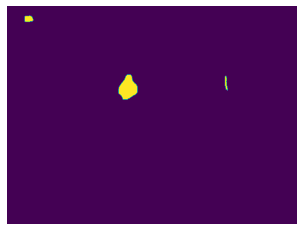

In [25]:

cfg.VP_NUM_TOPK = 50   # the retrieval number of viewpoint 
cfg.RANK_NUM_TOPK = 5  # the ranking number of full 3D orientation 



test_data_dir = datapath / 'lm' / 'test'          # path to the test dataset of BOP
obj_renderer = rendering.Renderer(width=cfg.RENDER_WIDTH, height=cfg.RENDER_HEIGHT)

scene_id = 1   # range [1, 15]
view_id = 0  # range [0, 1214]

scene_dir = pjoin(test_data_dir, '{:06d}'.format(scene_id))
color_file = pjoin(scene_dir, 'rgb/{:06d}.png'.format(view_id))
depth_file = pjoin(scene_dir, 'depth/{:06d}.png'.format(view_id))
mask_file = pjoin(scene_dir, 'mask_visib/{:06d}_{:06d}.png'.format(view_id, 0))

tar_obj_id = scene_id # object id equals the scene id for LM dataset
tar_obj_codebook = object_codebooks[tar_obj_id]

############## read the camera information ##############
cam_info_file = pjoin(scene_dir, 'scene_camera.json')
with open(cam_info_file, 'r') as cam_f:
    scene_camera_info = json.load(cam_f)
view_cam_info = scene_camera_info[str(view_id)]  # scene camera information        


############## read the ground truth pose for calculating errors ##############
gt_pose_file = os.path.join(scene_dir, 'scene_gt.json')
with open(gt_pose_file, 'r') as pose_f:
    pose_anno = json.load(pose_f)
view_pose = pose_anno[str(view_id)][0]
obj_gt_R = cfg.BOP_REF_POSE(torch.tensor(view_pose['cam_R_m2c'], dtype=torch.float32).view(3, 3))
obj_gt_t = torch.tensor(view_pose['cam_t_m2c'], dtype=torch.float32) * cfg.MODEL_SCALING


############## read the depth images and covert it from meter to millimeter ##############
view_depth = torch.tensor(np.array(Image.open(depth_file)), dtype=torch.float32) # HxW
view_depth *= view_cam_info['depth_scale']
view_depth *= cfg.MODEL_SCALING # convert to meter scale from millimeter scale
view_camK = torch.tensor(view_cam_info['cam_K'], dtype=torch.float32).view(3, 3)[None, ...] # 1x3x3
cam_K = view_camK.to(DEVICE)
view_depth = view_depth.to(DEVICE)


############## read rgb image for object segmentation ##############
view_timer = time.time() 
rgb_img = cv2.imread(color_file)
imread_cost = time.time() - view_timer

rcnn_timer = time.time()
output = predictor(rgb_img)
rcnn_pred_ids = output["instances"].pred_classes
rcnn_pred_masks = output["instances"].pred_masks
rcnn_pred_scores = output["instances"].scores
rcnn_cost = time.time() - rcnn_timer
###################### object segmentation ######################

tar_rcnn_d = tar_obj_id - 1
obj_masks = rcnn_pred_masks # NxHxW
obj_depths = view_depth[None, ...] * obj_masks
tar_obj_depths = obj_depths[tar_rcnn_d==rcnn_pred_ids]
tar_obj_masks = rcnn_pred_masks[tar_rcnn_d==rcnn_pred_ids]
tar_obj_scores = rcnn_pred_scores[tar_rcnn_d==rcnn_pred_ids]

mask_pixel_count = tar_obj_masks.view(tar_obj_masks.size(0), -1).sum(dim=1)
valid_idx = (mask_pixel_count >= 100)
if valid_idx.sum() == 0:
    mask_visib_ratio = mask_pixel_count / mask_pixel_count.max()
    valid_idx = mask_visib_ratio >= 0.05

tar_obj_masks = tar_obj_masks[valid_idx] # select the target object instance masks
tar_obj_depths = tar_obj_depths[valid_idx]
tar_obj_scores = tar_obj_scores[valid_idx]

pose_ret, rcnn_idx = utils.OVE6D_rcnn_full_pose(model_func=model_net, 
                                    obj_depths=tar_obj_depths,
                                    obj_masks=tar_obj_masks,
                                    obj_rcnn_scores=tar_obj_scores,
                                    obj_codebook=tar_obj_codebook, 
                                    cam_K=cam_K,
                                    config=cfg, 
                                    device=DEVICE,
                                    obj_renderer=obj_renderer, 
                                    return_rcnn_idx=True
                                    )
del obj_renderer

raw_pose_R = pose_ret['raw_R'] # without ICP
raw_pose_t = pose_ret['raw_t'] # without ICP

icp1_pose_R = pose_ret['icp1_R'] # with ICP after pose selection
icp1_pose_t = pose_ret['icp1_t'] # with ICP after pose selection

icpk_pose_R = pose_ret['icpk_R'] # with ICP before pose selection
icpk_pose_t = pose_ret['icpk_t'] # with ICP before pose selection

plt.imshow(tar_obj_masks.sum(dim=0).cpu())
plt.axis(False)

obj_name = rcnnIdx_to_lmCats_dict[tar_rcnn_d]

print('object: {}, the {}-th ({:.3f}) RCNN prediction is selected for estimating 6D pose. '.format(
    obj_name, rcnn_idx, tar_obj_scores[rcnn_idx]))
print('RCNN confs: {}'.format(tar_obj_scores.cpu().numpy()))

# Visualize the predicted pose

GT(Red): 	 Ape, diameter: 102.1mm, pose threshold(0.1d): 10.2mm
Raw(Blue): 	 rot error:7.6˚, tsl_err:6.7mm, add:7.9mm, adi:5.3mm
ICP1(Green): 	 rot error:3.4˚, tsl_err:9.6mm, add:9.4mm, adi:6.2mm
ICPK(Cyan): 	 rot error:4.3˚, tsl_err:9.7mm, add:9.5mm, adi:6.2mm


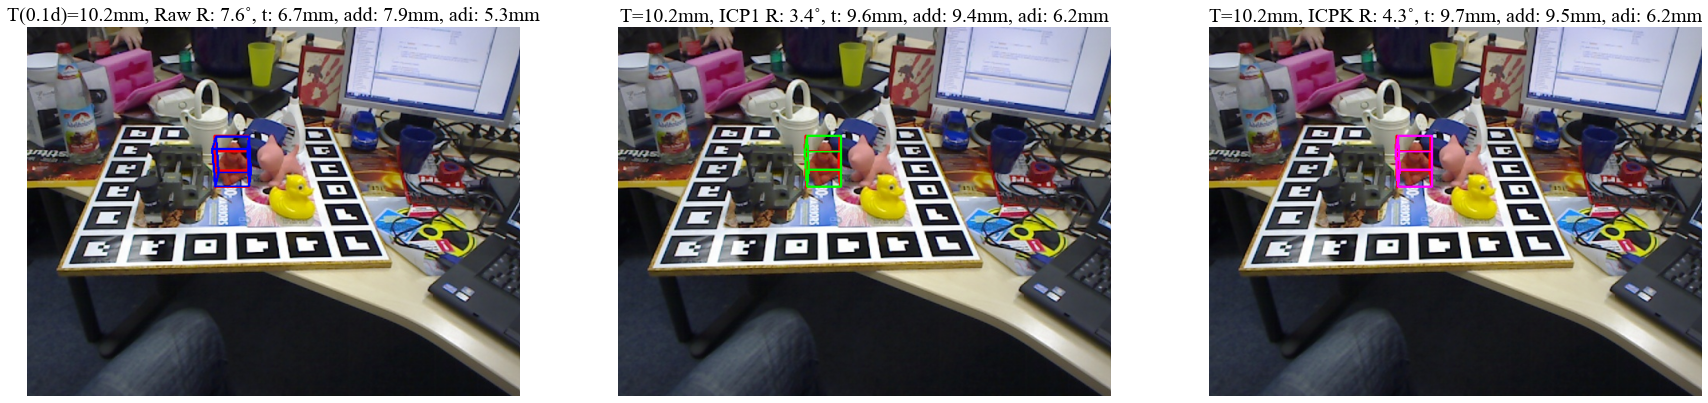

In [23]:
import misc 

obj_mesh = tar_obj_codebook['obj_mesh']

PD_raw_pose = torch.eye(4, dtype=torch.float32)
PD_raw_pose[:3, 3] = raw_pose_t
PD_raw_pose[:3, :3] = cfg.POSE_TO_BOP(raw_pose_R)


PD_icp1_pose = torch.eye(4, dtype=torch.float32)
PD_icp1_pose[:3, 3] = icp1_pose_t
PD_icp1_pose[:3, :3] = cfg.POSE_TO_BOP(icp1_pose_R)


PD_icpk_pose = torch.eye(4, dtype=torch.float32)
PD_icpk_pose[:3, 3] = icpk_pose_t
PD_icpk_pose[:3, :3] = cfg.POSE_TO_BOP(icpk_pose_R)


GT_pose = torch.eye(4, dtype=torch.float32)
GT_pose[:3, :3] = obj_gt_R
GT_pose[:3, 3] = obj_gt_t

obj_diameter = tar_obj_codebook['diameter']
corner_pts = obj_mesh.bounds  # object bounding box vertices
obj_pcl = obj_mesh.vertices
N_pcl = len(obj_pcl)
select_obj_idxes = torch.randperm(N_pcl)[:500]
select_obj_pts = torch.tensor(obj_pcl[select_obj_idxes])

GT_2D_bbox = misc.box_2D_shape(points=corner_pts, pose=GT_pose, K=cam_K)
PD_raw_2D_bbox = misc.box_2D_shape(points=corner_pts, pose=PD_raw_pose, K=cam_K)
PD_icp1_2D_bbox = misc.box_2D_shape(points=corner_pts, pose=PD_icp1_pose, K=cam_K)
PD_icpk_2D_bbox = misc.box_2D_shape(points=corner_pts, pose=PD_icpk_pose, K=cam_K)

GT_shape = misc.bbox_to_shape(GT_2D_bbox.tolist())
PD_raw_shape = misc.bbox_to_shape(PD_raw_2D_bbox.tolist())
PD_icp1_shape = misc.bbox_to_shape(PD_icp1_2D_bbox.tolist())
PD_icpk_shape = misc.bbox_to_shape(PD_icpk_2D_bbox.tolist())


pil_img = Image.open(color_file)
Raw_bbox_img = pil_img.copy()

draw = ImageDraw.Draw(Raw_bbox_img)
draw.line(GT_shape, (255, 0, 0), 3)  # Red 3D bbox for GT
draw.line(PD_raw_shape, (0, 0, 255), 3)  # Blue 3D bbox for OVE6D


ICP1_bbox_img = pil_img.copy()
draw = ImageDraw.Draw(ICP1_bbox_img)
draw.line(GT_shape, (255, 0, 0), 3)  # Red 3D bbox for GT
draw.line(PD_icp1_shape, (0, 255, 0), 3)  # Green 3D bbox for OVE6D with ICP after pose selection


ICPK_bbox_img = pil_img.copy()
draw = ImageDraw.Draw(ICPK_bbox_img)
draw.line(GT_shape, (255, 0, 0), 3)  # Red 3D bbox for GT
draw.line(PD_icpk_shape, (255, 0, 255), 3)  # Cyan 3D bbox for OVE6D with ICP before pose selection


##### calculate the pose errors ########
raw_R_err = utils.rotation_error(raw_pose_R, obj_gt_R)
icp1_R_err = utils.rotation_error(icp1_pose_R, obj_gt_R)
icpk_R_err = utils.rotation_error(icpk_pose_R, obj_gt_R)

raw_t_err = (((raw_pose_t - obj_gt_t)**2).sum())**0.5 * 1000
icp1_t_err = (((icp1_pose_t - obj_gt_t)**2).sum())**0.5 * 1000
icpk_t_err = (((icpk_pose_t - obj_gt_t)**2).sum())**0.5 * 1000


raw_add_err = misc.add(R_est=raw_pose_R.numpy(), t_est=raw_pose_t.numpy(), 
                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
                        pts=select_obj_pts.numpy())*1000
raw_adi_err = misc.adi(R_est=raw_pose_R.numpy(), t_est=raw_pose_t.numpy(), 
                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
                        pts=select_obj_pts.numpy())*1000

icp1_add_err = misc.add(R_est=icp1_pose_R.numpy(), t_est=icp1_pose_t.numpy(), 
                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
                        pts=select_obj_pts.numpy())*1000
icp1_adi_err = misc.adi(R_est=icp1_pose_R.numpy(), t_est=icp1_pose_t.numpy(), 
                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
                        pts=select_obj_pts.numpy())*1000

icpk_add_err = misc.add(R_est=icpk_pose_R.numpy(), t_est=icpk_pose_t.numpy(), 
                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
                        pts=select_obj_pts.numpy())*1000
icpk_adi_err = misc.adi(R_est=icpk_pose_R.numpy(), t_est=icpk_pose_t.numpy(), 
                        R_gt=obj_gt_R.numpy(), t_gt=obj_gt_t.numpy(), 
                        pts=select_obj_pts.numpy())*1000



fig, ax = plt.subplots(1,3,figsize=(30, 10))
ax[0].imshow(Raw_bbox_img)
ax[0].set_title("T(0.1d)={:.1f}mm, Raw R: {:.1f}˚, t: {:.1f}mm, add: {:.1f}mm, adi: {:.1f}mm".format(
    obj_diameter * 100, raw_R_err, raw_t_err, raw_add_err, raw_adi_err), fontsize=20)
ax[1].imshow(ICP1_bbox_img)
ax[1].set_title("T={:.1f}mm, ICP1 R: {:.1f}˚, t: {:.1f}mm, add: {:.1f}mm, adi: {:.1f}mm".format(
    obj_diameter * 100, icp1_R_err, icp1_t_err, icp1_add_err, icp1_adi_err), fontsize=20)
ax[2].imshow(ICPK_bbox_img)
ax[2].set_title("T={:.1f}mm, ICPK R: {:.1f}˚, t: {:.1f}mm, add: {:.1f}mm, adi: {:.1f}mm".format(
    obj_diameter * 100, icpk_R_err, icpk_t_err, icpk_add_err, icpk_adi_err), fontsize=20)
ax[0].axis(False)
ax[1].axis(False)
ax[2].axis(False)

# print('object diameter: {:.1f}mm, 0.1d:{:.1f}mm'.format(obj_diameter*1000, obj_diameter*100))
print('GT(Red): \t {}, diameter: {:.1f}mm, pose threshold(0.1d): {:.1f}mm'.format(obj_name, obj_diameter*1000, obj_diameter*100))
print('Raw(Blue): \t rot error:{:.1f}˚, tsl_err:{:.1f}mm, add:{:.1f}mm, adi:{:.1f}mm'.format(raw_R_err, raw_t_err, raw_add_err, raw_adi_err))
print('ICP1(Green): \t rot error:{:.1f}˚, tsl_err:{:.1f}mm, add:{:.1f}mm, adi:{:.1f}mm'.format(icp1_R_err, icp1_t_err, icp1_add_err, icp1_adi_err))
print('ICPK(Cyan): \t rot error:{:.1f}˚, tsl_err:{:.1f}mm, add:{:.1f}mm, adi:{:.1f}mm'.format(icpk_R_err, icpk_t_err, icpk_add_err, icpk_adi_err))

